In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
import pickle
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
import json
import IO
from sklearn import linear_model
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 
from collections import OrderedDict
import seaborn as sb

def get_int_runs(subject_id, subfolder):
    """
    :param patient_idx:
    :return: list with all run files for the given patient
    """
    os.listdir(settings['out_path'])

    if 'right' in str(subfolder):
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_right') and i.endswith('.p')]
    else:
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_left') and i.endswith('.p')]

    return list_subject

In [2]:
settings = {}
settings['frequencyranges']=[[4, 8], [8, 12], [13, 20], [20, 35], [13, 35], [60, 80], [90, 200], [60, 200]]
settings['seglengths']=[1, 2, 2, 3, 3, 3, 10, 10, 10]
settings['num_patients']=['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
settings['BIDS_path'] = r"C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH"
settings['out_path'] = r"C:\Users\ICN_admin\Documents\ECOGVSTN\data\Int_old_grid"
settings['out_path_process'] = r'C:\Users\ICN_admin\Documents\ECOGVSTN\data\Features_ind_channels'

In [3]:
# here: figure out the best channel from the LM_ind dataset, then plot the coefficient of a LM trained on that ch

In [4]:
def get_ind_weights(loc_="ECOG", mod_="CON"):
    res_ = np.zeros([11,8,10])
    for sub_idx in np.arange(0, len(settings['num_patients']), 1):
        sess  = [f for f in os.listdir(settings["out_path_process"]) if (loc_ in f) \
                 and settings["num_patients"][sub_idx] in f] 

        max_ = -1
        for sess_ in sess:
            dat = np.load(os.path.join(settings["out_path_process"], sess_), allow_pickle=True).tolist()

            if np.max(dat["score_te"][mod_]) > max_:
                max_ = np.max(dat["score_te"][mod_])
                argmax_ = np.argmax(dat["score_te"][mod_])
                X = dat["X"][:,argmax_, :]
                y = dat["y"][mod_][argmax_]
            for fband in range(8):
                for time_lag in range(10):
                    if time_lag == 0: 
                        X_ = X[:, fband] 
                    else:
                        X_ = X[:-time_lag, fband]
                    y_ = y[time_lag:]
                    res_[sub_idx, fband, time_lag] = \
                        linear_model.LinearRegression().fit(np.expand_dims(X_, axis=1), y_).coef_[0]
    return np.mean(np.array(res_), axis=0)

In [5]:
def get_ind_weights(loc_="ECOG", mod_="CON"):
    res_ = np.zeros([11,8,10])
    for sub_idx in np.arange(0, len(settings['num_patients']), 1):
        sess  = [f for f in os.listdir(settings["out_path_process"]) if (loc_ in f) \
                 and settings["num_patients"][sub_idx] in f] 

        max_ = -1
        for sess_ in sess:
            dat = np.load(os.path.join(settings["out_path_process"], sess_), allow_pickle=True).tolist()

            if np.max(dat["score_te"][mod_]) > max_:
                max_ = np.max(dat["score_te"][mod_])
                argmax_ = np.argmax(dat["score_te"][mod_])
                X = dat["X"][:,argmax_, :]
                y = dat["y"][mod_][argmax_]
            for fband in range(8):
                for time_lag in range(10):
                    if time_lag == 0: 
                        X_ = X[:, fband] 
                    else:
                        X_ = X[:-time_lag, fband]
                    y_ = y[time_lag:]
                    res_[sub_idx, fband, time_lag] = \
                        linear_model.LinearRegression().fit(np.expand_dims(X_, axis=1), y_).coef_[0]
    return np.array(res_)

In [6]:
weights_ECOG_CON = get_ind_weights(loc_="ECOG", mod_="CON")
weights_ECOG_IPS = get_ind_weights(loc_="ECOG", mod_="IPS")

In [8]:
fbs = [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                         r'$a\beta$', r'$l\gamma$', r'$HFA$', r'$a\gamma$']

df_plot = pd.DataFrame()

for sub in range(11):
    for fb_idx, fb in enumerate(fbs):
        df_plot = df_plot.append(
            {
                "Frequency bands":fbs[fb_idx],
                "lat" : "CON",
                "loc" : "ECOG",
                "Weights" : weights_ECOG_CON[sub,fb_idx,0]
            },
            ignore_index=True
        )

        df_plot = df_plot.append(
            {
                "Frequency bands":fbs[fb_idx],
                "lat" : "IPS",
                "loc" : "ECOG",
                "Weights" : weights_ECOG_IPS[sub,fb_idx,0]
            },
            ignore_index=True
        )


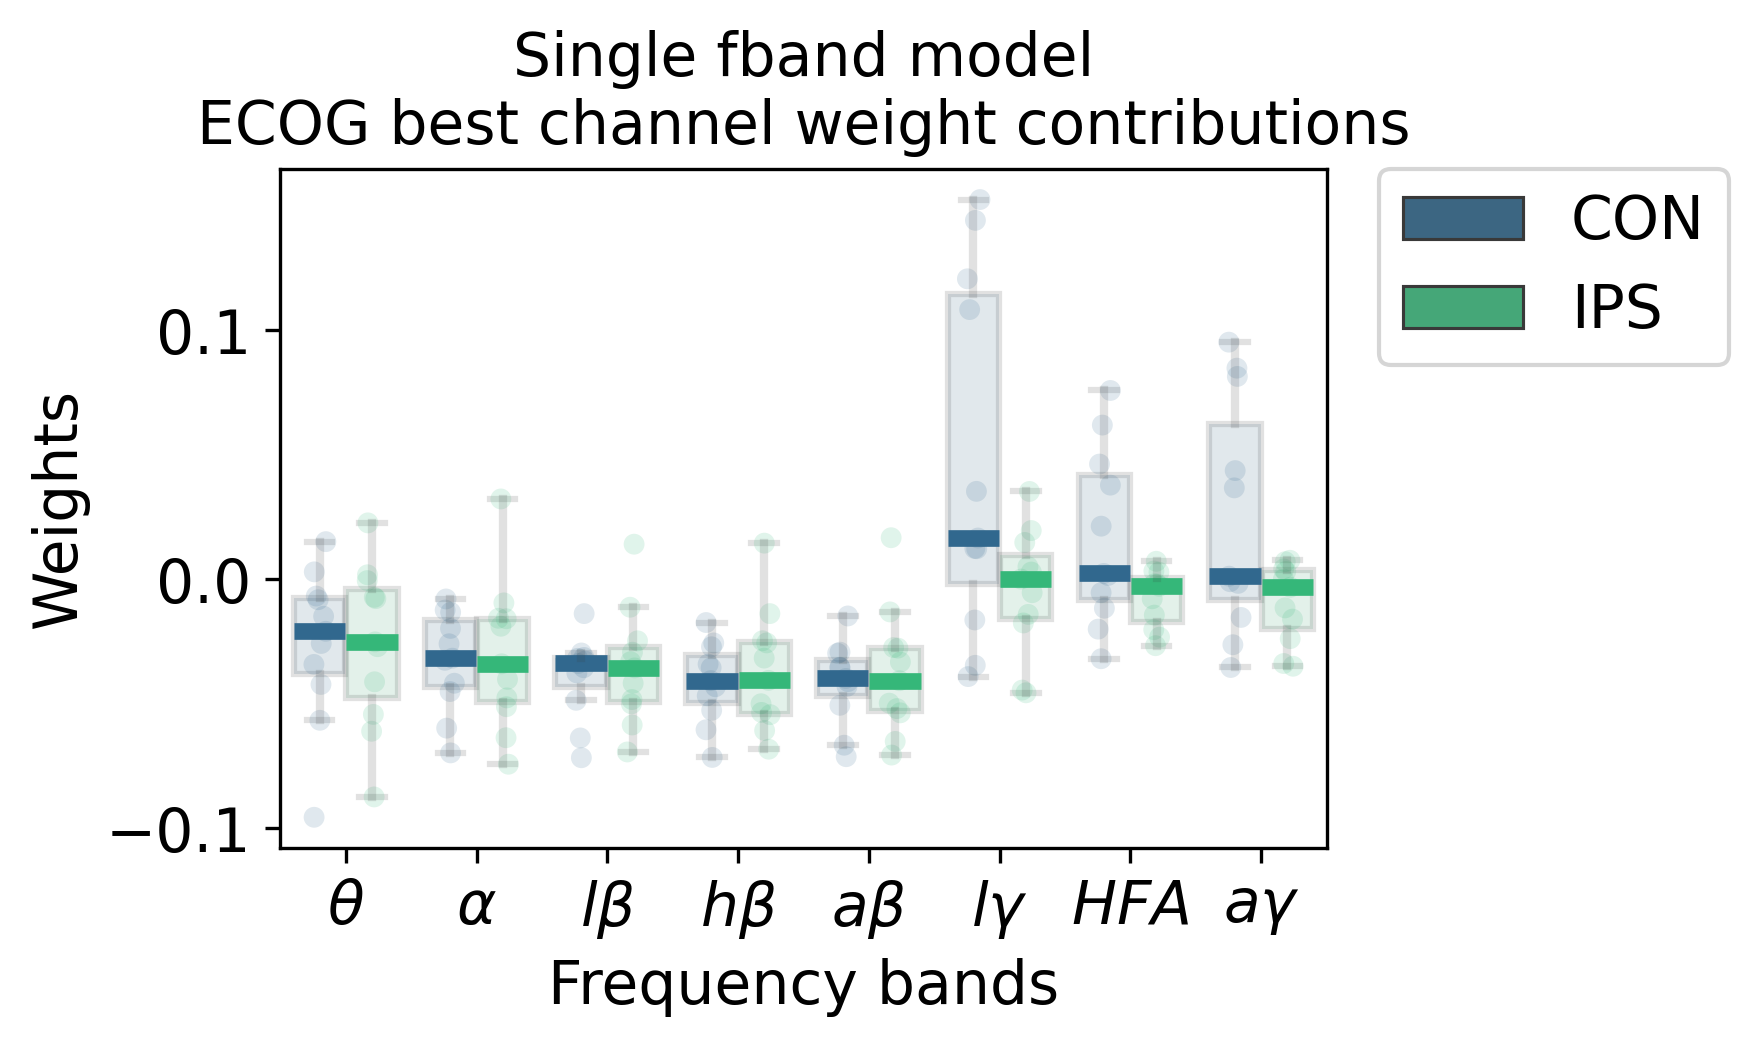

In [11]:
df = df_plot
params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

alpha_box = 0.15
alpha_median = 1
plt.figure(figsize=(4.5,3), dpi=300)
ax = sb.boxplot(x="Frequency bands", y="Weights", hue="lat", 
           data=df, palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=4, alpha=0.0124))# , color="gray"

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .1))

hue_colors = sb.color_palette("viridis", df["lat"].unique().shape[0])
switch_ = 0
for line in ax.lines:
    if line.get_alpha() == 0.0124:
        
        line.set_color(hue_colors[switch_])
        switch_ += 1
        
        if switch_ >= len(hue_colors):
            switch_ = 0
            
        line.set_alpha(alpha_median)
        
ax = sb.stripplot(x="Frequency bands", y="Weights", hue="lat", #order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
             data=df, palette="viridis", dodge=True, s=5, alpha=alpha_box)


# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Single fband model\nECOG best channel weight contributions")
plt.savefig("Point 6 - Single fband weight contributions.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [6]:
def plot_weights(arr, title_, cmap=False):
    plt.imshow(arr) #cmap='seismic')
    plt.clim(-0.04, 0.04)
    plt.xticks(np.arange(10), ['0', '-100', '-200', '-300', '-400', '-500', '-600', '-700', '-800', '-900'], 
              rotation=45, horizontalalignment = 'center')
    plt.yticks(np.arange(8), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
    plt.xlabel('Time [ms]')
    plt.ylabel('Frequency Band')
    cbar = plt.colorbar()
    cbar.set_label('Weight')
    plt.xlim(-0.5, 9.5)
    plt.ylim(-0.5, 7.5)
    plt.gca().invert_xaxis()
    #plt.gca().invert_yaxis()
    plt.title(title_)

In [6]:
ECOG_CON = get_ind_weights(loc_="ECOG", mod_="CON")
ECOG_IPS = get_ind_weights(loc_="ECOG", mod_="IPS")
STN_CON = get_ind_weights(loc_="STN", mod_="CON")
STN_IPS = get_ind_weights(loc_="STN", mod_="IPS")

In [8]:
FIGURE_2B = {
    "ECOG_CON" : ECOG_CON,
    "ECOG_IPS" : ECOG_IPS,
    "STN_CON" :  STN_CON,
    "STN_IPS" : STN_IPS}

In [10]:
from scipy import io
io.savemat('FIGURE_2B.mat', FIGURE_2B)

In [9]:
import pickle
with open('FIGURE_2B.p', 'wb') as handle:
    pickle.dump(FIGURE_2B, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
import pickle
with open('FIGURE_2B.p', 'rb') as handle:
    FIGURE_2B = pickle.load(handle)

In [8]:
from scipy import io
io.savemat('FIGURE_2B.mat', FIGURE_2B)

In [15]:
ECOG_CON = FIGURE_2B["ECOG_CON"]
ECOG_IPS = FIGURE_2B["ECOG_IPS"]
STN_CON = FIGURE_2B["STN_CON"]
STN_IPS = FIGURE_2B["STN_IPS"]

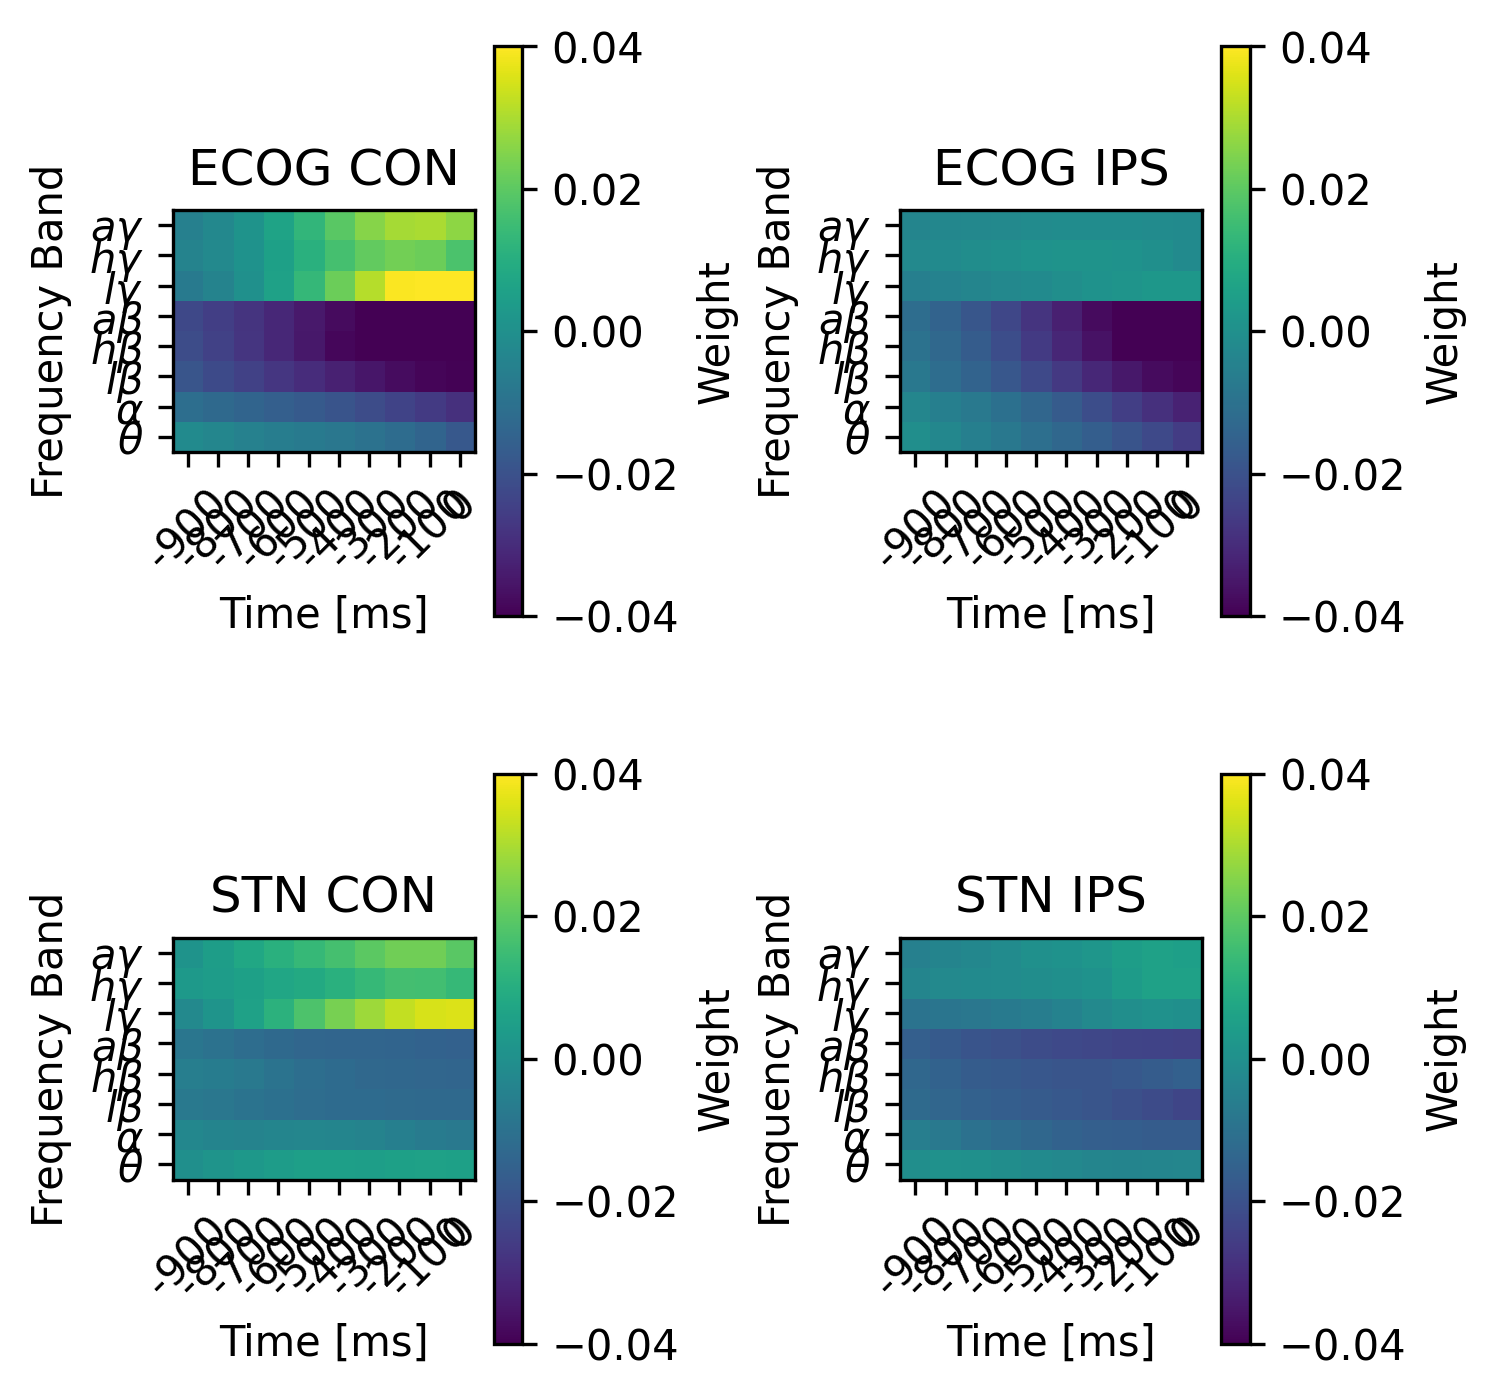

In [6]:
#plt.style.use('dark_background')
plt.figure(figsize=(5,5), dpi=300)
plt.subplot(2,2,1)
plot_weights(get_ind_weights(loc_="ECOG", mod_="CON"), 'ECOG CON')
plt.subplot(2,2,2)
plot_weights(get_ind_weights(loc_="ECOG", mod_="IPS"), 'ECOG IPS')
plt.subplot(2,2,3)
plot_weights(get_ind_weights(loc_="STN", mod_="CON"), 'STN CON')
plt.subplot(2,2,4)
plot_weights(get_ind_weights(loc_="STN", mod_="IPS"), 'STN IPS')
plt.tight_layout()

In [23]:
def plot_weights(arr, title_, cmap=False):
    plt.imshow(arr) #cmap='seismic')
    plt.clim(-0.04, 0.04)
    plt.xticks(np.arange(10), ['0', '-100', '-200', '-300', '-400', '-500', '-600', '-700', '-800', '-900'], 
              rotation=45, horizontalalignment = 'center')
    plt.yticks(np.arange(8), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$HFA$', r'$a\gamma$'])
    plt.xlabel('Time [ms]')
    plt.ylabel('Frequency Band')
    cbar = plt.colorbar()
    cbar.set_label('Weight')
    plt.xlim(-0.5, 9.5)
    plt.ylim(-0.5, 7.5)
    plt.gca().invert_xaxis()
    #plt.gca().invert_yaxis()
    plt.title(title_)

In [17]:
#plt.style.use('dark_background')
params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

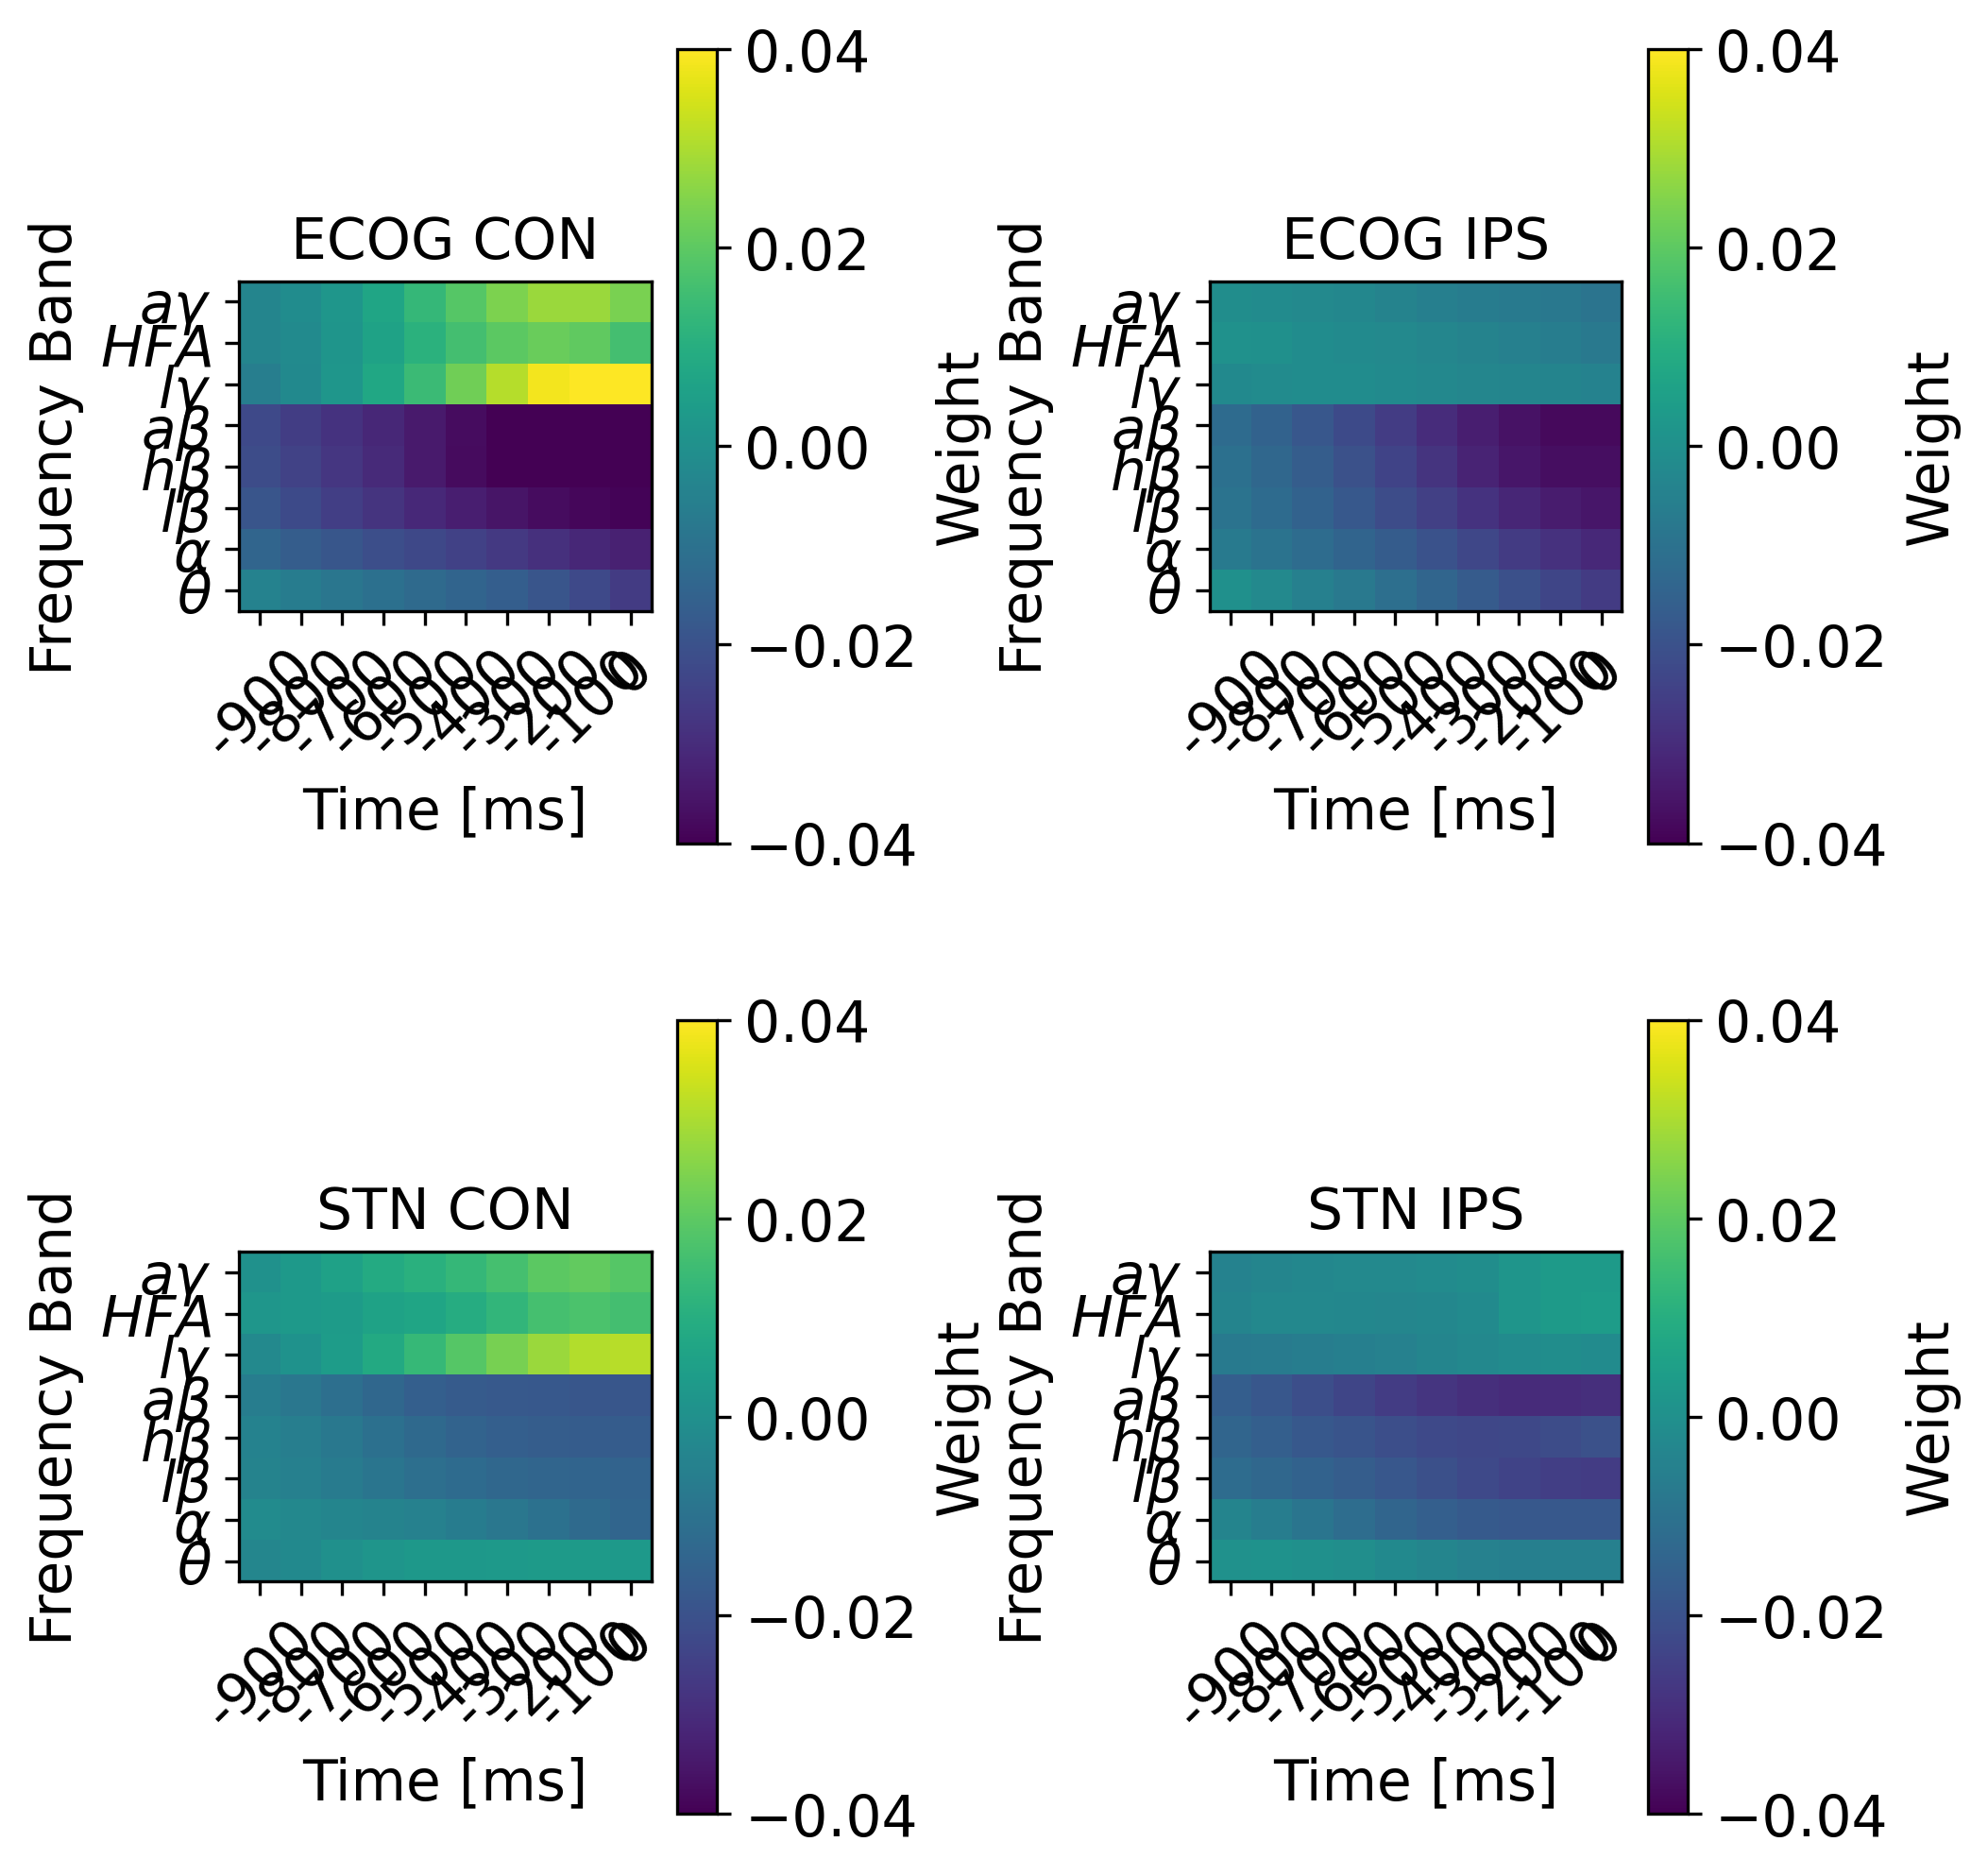

In [24]:
plt.figure(figsize=(7,7), dpi=300)
plt.subplot(2,2,1)
plot_weights(get_ind_weights(loc_="ECOG", mod_="CON").mean(axis=0), 'ECOG CON')
plt.subplot(2,2,2)
plot_weights(get_ind_weights(loc_="ECOG", mod_="IPS").mean(axis=0), 'ECOG IPS')
plt.subplot(2,2,3)
plot_weights(get_ind_weights(loc_="STN", mod_="CON").mean(axis=0), 'STN CON')
plt.subplot(2,2,4)
plot_weights(get_ind_weights(loc_="STN", mod_="IPS").mean(axis=0), 'STN IPS')
plt.tight_layout()

plt.savefig("Figure 2 B with colorbar.pdf", bbox_inches='tight', dpi=300)